In [68]:
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Simulate example data

In [2]:
# Define number of genes and samples
n_genes = 500
n_samples = 1000

np.random.seed(1234)

In [3]:
# Create an embedding (n_genes x 10) where the first two dimensions are predictive of whether a gene is associated with the trait. 
# In this example the first 20 genes are associated with the trait

emb_dim = 10
emb_sim = np.random.randn(n_genes, emb_dim)

emb_sim[:, 0:2] = np.zeros((n_genes, 2))  # Make the first two dimensions of all genes zero
emb_sim[0:10, 0] = np.ones(10)            # Make the first dimension of the genes 1-10 as one
emb_sim[10:20, 1] = np.ones(10)           # Make the second dimension of the genes 11-20 as one

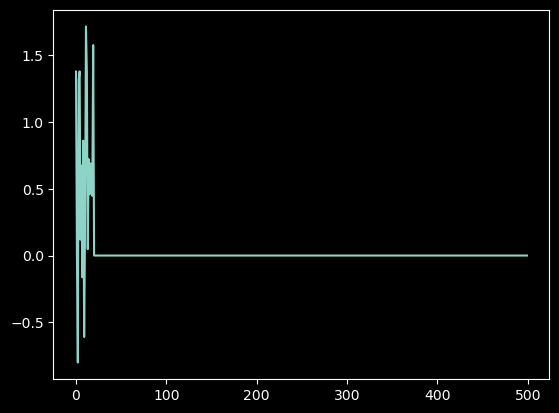

In [4]:
# beta simulation
# The first 10 genes have a random association with the trait, the next 10 are positively related, and the rest are unrelated

beta_sim = np.zeros(n_genes)
beta_sim[0:10] = np.random.randn(10)
beta_sim[10:20] = np.abs(np.random.randn(10))
plt.plot(beta_sim)

In [5]:
# Simulate a population by randomly sampling (bernoulli)

# train genotype matrix
gt_train = np.random.binomial(1, p = 0.05, size = (n_samples, n_genes))

# val genotype matrix
gt_val = np.random.binomial(1, p = 0.05, size = (n_samples, n_genes))

# test genotype matrix
gt_test = np.random.binomial(1, p = 0.05, size = (n_samples, n_genes))

In [6]:
noise_ratio = 0.5

# Compute simulated phenotype for train, validation, and test
y_train = gt_train @ beta_sim + noise_ratio * np.random.randn(n_samples)
y_val = gt_val @ beta_sim + noise_ratio * np.random.randn(n_samples)
y_test = gt_test @ beta_sim + noise_ratio * np.random.randn(n_samples)

# Linear regression

In [54]:

lm = LinearRegression()

gt_trainval = np.concatenate([gt_train, gt_val], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

lm.fit(gt_trainval, y_trainval)

LinearRegression()

Test R2: 0.6593073367186126


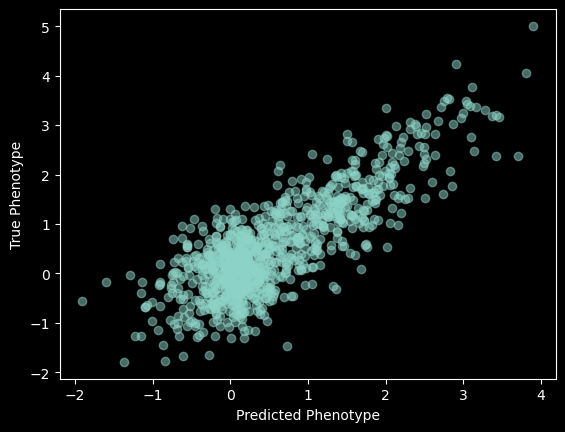

In [63]:
print('Test R2:', r2_score(y_test, lm.predict(gt_test)))

plt.scatter(lm.predict(gt_test), y_test, alpha=0.5)
plt.xlabel('Predicted Phenotype')
plt.ylabel('True Phenotype')
plt.show()

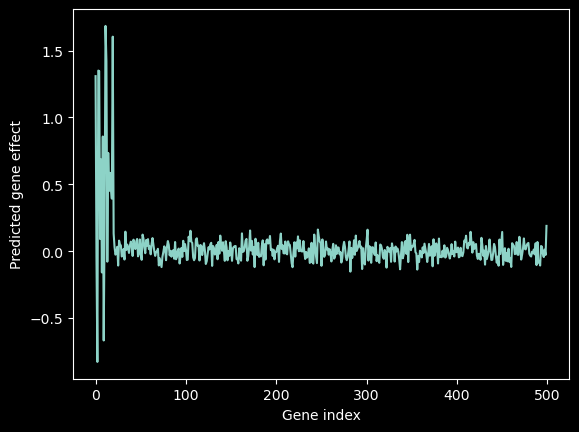

In [62]:
plt.plot(lm.coef_)
plt.xlabel('Gene index')
plt.ylabel('Predicted gene effect')
plt.show()

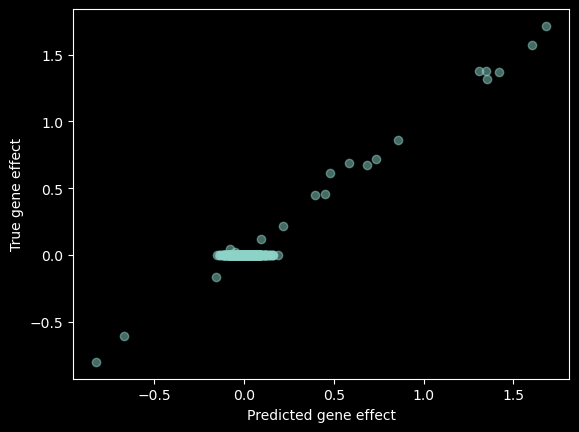

In [61]:
# Scatter plot of true vs predicted gene effects

plt.scatter(lm.coef_, beta_sim, alpha=0.5)
plt.xlabel('Predicted gene effect')
plt.ylabel('True gene effect')
plt.show()

# FuncRVP on simulated data

In [75]:
# Import scripts folder to the path

if "../scripts" not in sys.path:
    sys.path.append("../scripts/")

In [74]:
import torch
import g2p_bayes_cov_skipcon as g2p_bayes_cov  # From 'scripts' folder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
# FuncRVP needs a covariate matrix as well, we will initialize this as zero tensors

cov_train = np.zeros((n_samples, 1))
cov_val = np.zeros((n_samples, 1))
cov_test = np.zeros((n_samples, 1))

In [34]:
# Define the model parameters

num_epochs = 500

args = {
    "trait": 'simulation',
    "embedding_type": 'simulation',
    "skip_con": True,  # Skip connection in the network
    "normalize_embeddings": False, #z-score normalize embeddings
    "embedding_dim": emb_sim.shape[1], #dimension of embedding
    "n_genes": gt_train.shape[1], #number of genes
    "n_samples": y_train.shape[0], #number of training samples
    "learning_rate": 0.001, #lr for Adam optimizer 
    "epochs": num_epochs, #Number of epochs to train
    "nonlinearity": "softplus", #choose from ['relu', 'silu', 'elu', 'gelu', 'softplus']
    "weight_decay": 0, #L2 penalty on trainable parameters
    "batch_size": 8*1024,
    "n_hidden": 3, #number of hidden layers in f(E)
    "hidden_dim": 8, #number of neurons in each hidden layer of f(E)
    "last_layer_bias": -7, #initialization of bias term of last layer in f(E)
    "early_stopping": False, #If True, stops training if val r2 is lower than covariate r2 for >5 epochs
    "y_var_init": y_train.var(), #initialization of variance of y
    "alpha_L1_fE": 0, #L1 penalty weighting of f(E)
    "base_var_init": 1e-5, #Constant variance value to be added to f(E)
}

# Initialize the model.
g2p_cov_model = g2p_bayes_cov.G2P_Model(emb_dim=args["embedding_dim"], n_cov=cov_train.shape[1], n_hidden=args["n_hidden"], hiddem_dim=args["hidden_dim"], skip_con=args["skip_con"], last_layer_bias=args["last_layer_bias"], nonlinearity=args["nonlinearity"], y_var_init=args["y_var_init"], base_var_init=args["base_var_init"], n_genes=args["n_genes"], device=device)


g2p_cov_model = g2p_cov_model.to(device)

print("Number of trainable parameters in model:", sum(p.numel() for p in g2p_cov_model.parameters() if p.requires_grad))


Number of trainable parameters in model: 304


In [ ]:
# Fit the model

g2p_cov_model.fit_model(gt_train, cov_train, y_train, emb_sim,
                        args,
                        G_val=gt_val, C_val=cov_val, y_val=y_val,
                        fast=False, #Compute posterior distribution after every epoch. Necessary for computing validation r2. 
                        device=device)

Covariates r2 on val: -0.00258381934326235
After epoch 0: Train loss: 1418.81128, Validation loss: 1402.93652, Train r2: 0.16533, Val r2: 0.09565, Epoch time: 0.07s
After epoch 1: Train loss: 1418.45251, Validation loss: 1402.90015, Train r2: 0.16491, Val r2: 0.09547, Epoch time: 0.16s
After epoch 2: Train loss: 1418.08557, Validation loss: 1402.84985, Train r2: 0.16459, Val r2: 0.09535, Epoch time: 0.17s
After epoch 3: Train loss: 1417.71045, Validation loss: 1402.78394, Train r2: 0.16436, Val r2: 0.09531, Epoch time: 0.17s
After epoch 4: Train loss: 1417.3269, Validation loss: 1402.69922, Train r2: 0.16425, Val r2: 0.09536, Epoch time: 0.15s
After epoch 5: Train loss: 1416.93433, Validation loss: 1402.59595, Train r2: 0.16424, Val r2: 0.09548, Epoch time: 0.17s
After epoch 6: Train loss: 1416.53271, Validation loss: 1402.46838, Train r2: 0.16436, Val r2: 0.09571, Epoch time: 0.18s
After epoch 7: Train loss: 1416.12158, Validation loss: 1402.31018, Train r2: 0.16464, Val r2: 0.09607, 

# Analyse model results

Test R2 (using model at epoch with best validation R2):
 0.7429322498767176


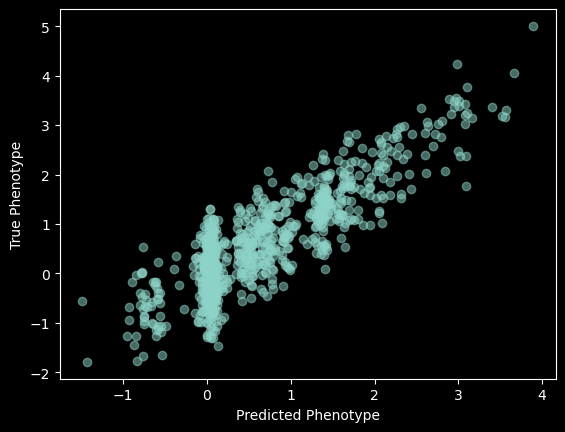

In [ ]:
# Test phenotype prediction R2 using FuncRVP is better than linear regression

funcrvp_pred = gt_test @ g2p_cov_model.best_r2_trainval_mean_beta + cov_test @ g2p_cov_model.best_r2_gamma + g2p_cov_model.best_r2_intercept
test_r2 = r2_score(y_test, funcrvp_pred)
print("Test R2 (using model at epoch with best validation R2):\n", test_r2)

plt.scatter(funcrvp_pred, y_test, alpha=0.5) 
plt.xlabel('Predicted Phenotype')
plt.ylabel('True Phenotype')
plt.show()

<Axes: >

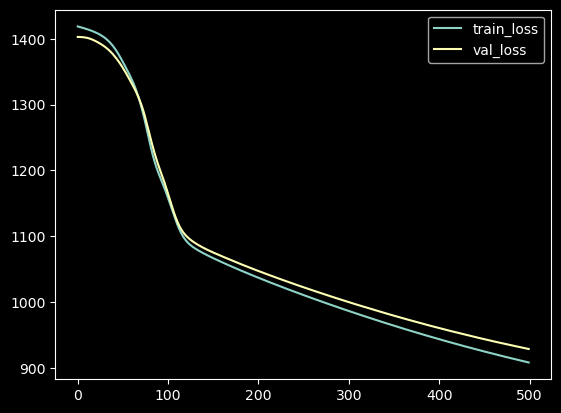

In [38]:
pd.DataFrame({"train_loss": g2p_cov_model.epoch_loss_list, "val_loss": g2p_cov_model.val_list}).plot()

<Axes: >

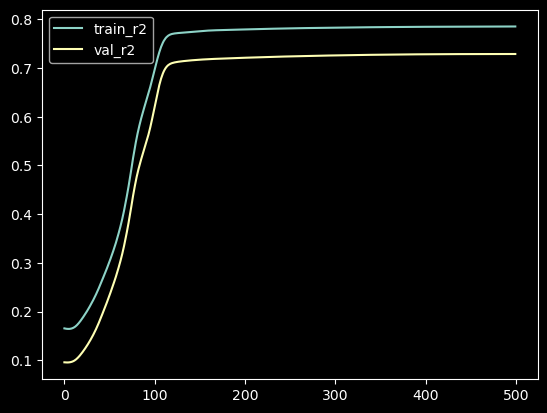

In [39]:
pd.DataFrame({"train_r2": g2p_cov_model.train_r2_list, "val_r2": g2p_cov_model.val_r2_list}).plot()

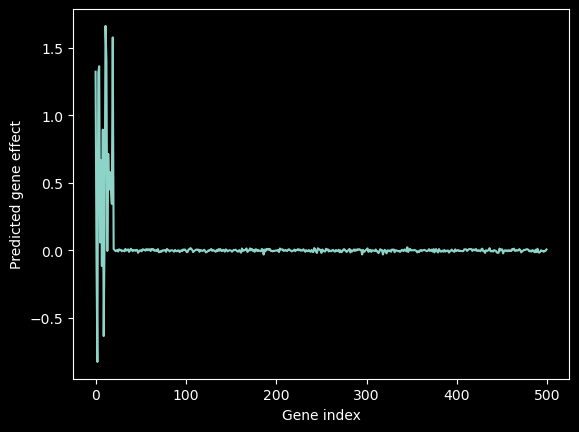

In [ ]:
# Visualizing gene effect estimation of FuncRVP

plt.plot(g2p_cov_model.best_r2_trainval_mean_beta)
plt.xlabel('Gene index')
plt.ylabel('Predicted gene effect')
plt.show()

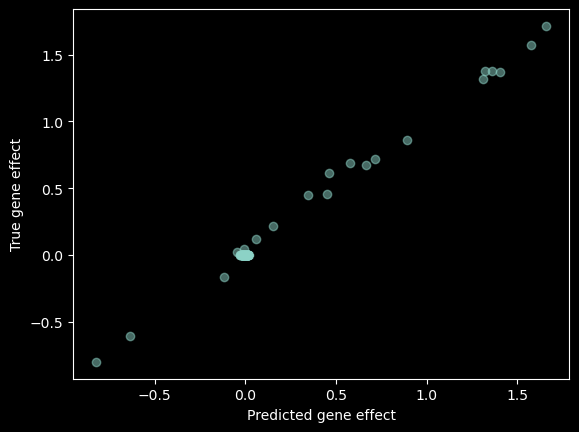

In [ ]:
# Gene effect estimates of FuncRVP are much closer to ground truth than linear regression

plt.scatter(g2p_cov_model.best_r2_trainval_mean_beta, beta_sim, alpha=0.5)
plt.xlabel('Predicted gene effect')
plt.ylabel('True gene effect')
plt.show()